In [27]:
import os 
import time 
import numpy as np 
import pandas as pd 
import cv2 
import matplotlib.pyplot as plt 
from tqdm import tqdm_notebook, trange
import gc

%matplotlib inline 

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [28]:
path = 'C:/Users/Korisnik/Desktop/diplomski2'
train_path = path + '/train/'
test_path = path + '/test/'
labels = pd.read_csv(path + '/train_labels.csv')
submission = pd.read_csv(path + '/sample_submission.csv')

In [29]:
train_labels, val_labels = train_test_split(labels, stratify=labels["label"], test_size=0.1)

from glob import glob
df = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))})
df['id'] = df.path.map(lambda x: os.path.basename(x).split(".")[0])
print(labels.columns)  
df = df.merge(labels, on="id")

df.head(10)

Index(['id', 'label'], dtype='object')


,path,id,label
0,C:/Users/Korisnik/Desktop/diplomski2/train\000...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,C:/Users/Korisnik/Desktop/diplomski2/train\000...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,C:/Users/Korisnik/Desktop/diplomski2/train\000...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,C:/Users/Korisnik/Desktop/diplomski2/train\000...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,C:/Users/Korisnik/Desktop/diplomski2/train\000...,0000da768d06b879e5754c43e2298ce48726f722,1
5,C:/Users/Korisnik/Desktop/diplomski2/train\000...,0000f8a4da4c286eee5cf1b0d2ab82f979989f7b,0
6,C:/Users/Korisnik/Desktop/diplomski2/train\000...,00010f78ea8f878117500c445a658e5857f4e304,0
7,C:/Users/Korisnik/Desktop/diplomski2/train\000...,00011545a495817817c6943583b294c900a137b8,0
8,C:/Users/Korisnik/Desktop/diplomski2/train\000...,000126ec42770c7568204e2f6e07eb9a07d5e121,0
9,C:/Users/Korisnik/Desktop/diplomski2/train\000...,00014e39b5df5f80df56f18a0a049d1cc6de430a,1


In [30]:
print("Number of images:")
print(f"Training set: {len(train_labels)} images")
print(f"Validation set: {len(val_labels)} images")
print(f"Test set: {len(submission)} images")

Number of images:
Training set: 198022 images
Validation set: 22003 images
Test set: 57458 images


In [31]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce GTX 1660 Ti


In [32]:
def load_data(N, df):
    paths = df['path'].values[:N] 
    y = np.squeeze(df[['label']].to_numpy())[0:N]

    X = np.array([cv2.imread(p) if cv2.imread(p) is not None else np.zeros((96,96,3), dtype=np.uint8) for p in paths])

    return X, y

In [33]:
N = 1000
X, y = load_data(N, df)

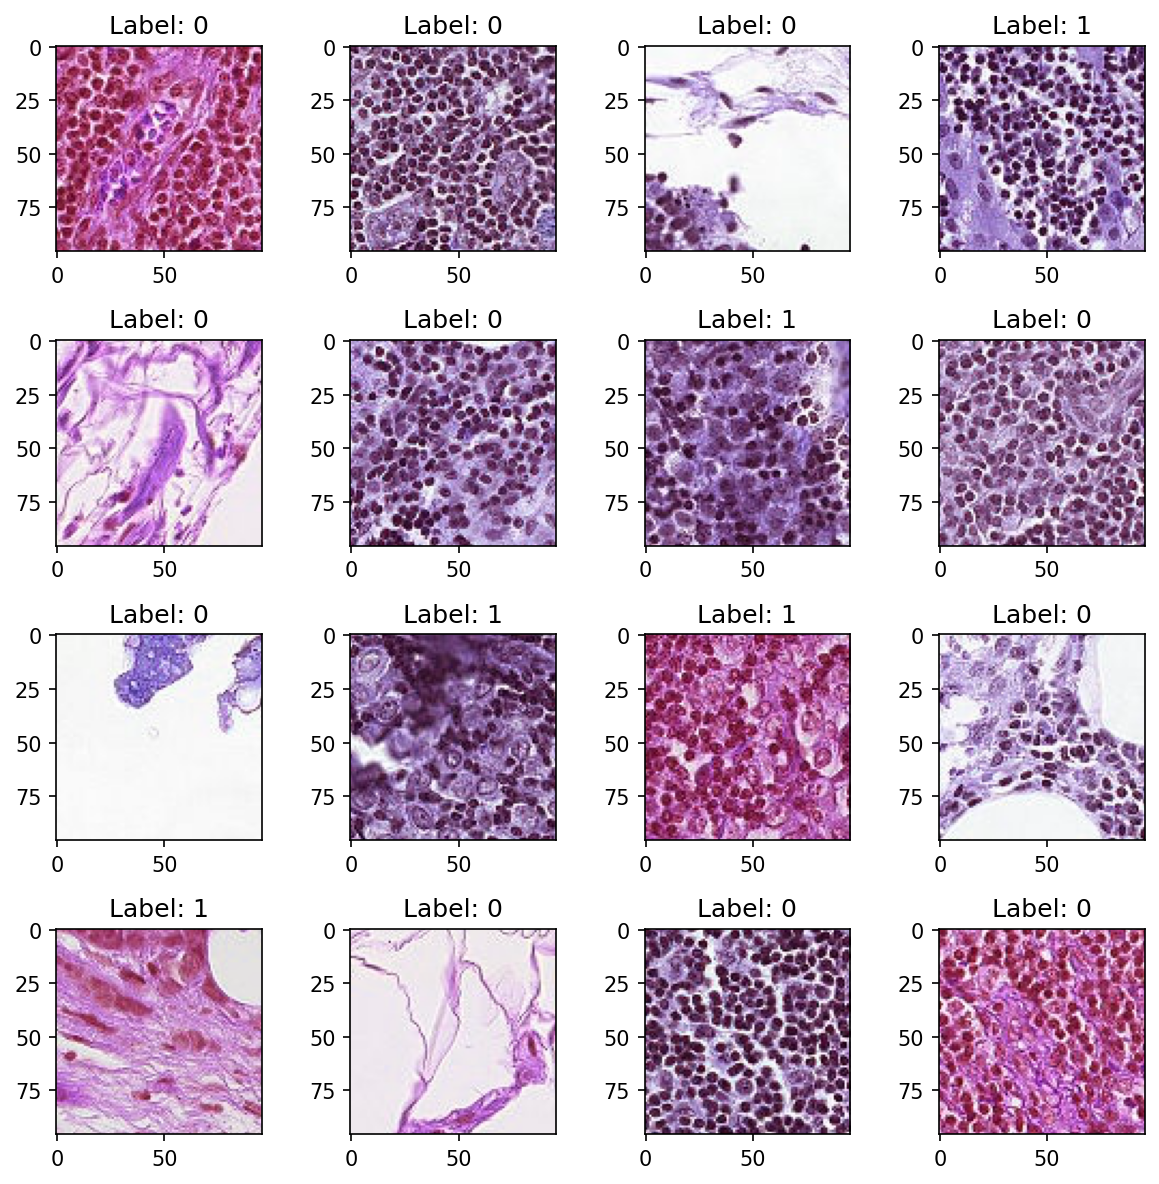

In [34]:
fig = plt.figure(figsize = (8,8), dpi = 150)
np.random.seed(100)
image_count = 16

for plot_idx, image_idx in enumerate(np.random.randint(0, N, image_count)):
    ax = fig.add_subplot(4, 4, plot_idx + 1)
    ax.imshow(X[image_idx])
    ax.set_title('Label: ' + str(y[image_idx]))

plt.tight_layout()
plt.show()

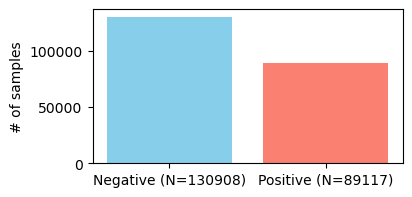

In [35]:
import matplotlib.pyplot as plt

counts = labels["label"].value_counts()
plt.figure(figsize=(4, 2), dpi=100)
plt.bar(counts.index, counts.values, color=['skyblue', 'salmon'])
plt.xticks(
    [0, 1],
    [f'Negative (N={counts[0]})', f'Positive (N={counts[1]})']
)
plt.ylabel('# of samples')
plt.show()


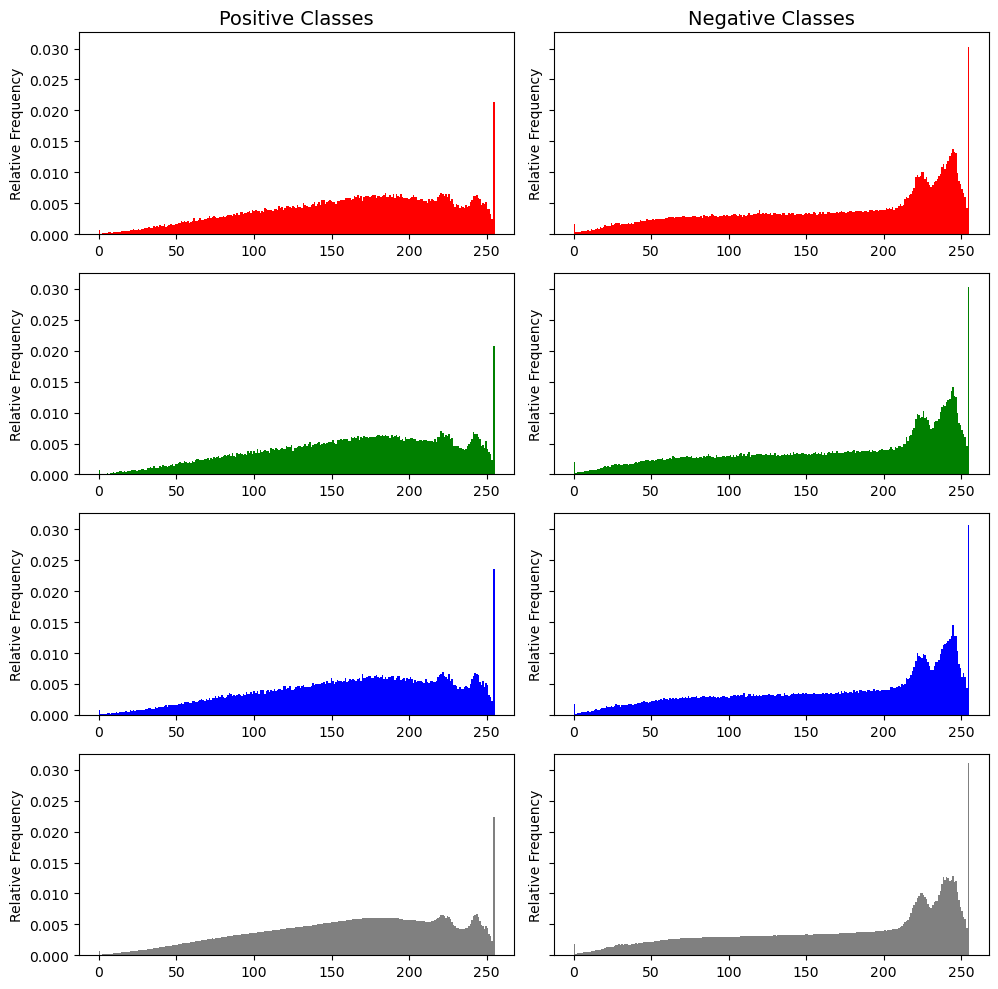

In [36]:
nr_of_bins = 256 
fig, axs = plt.subplots(4, 2, sharey=True, figsize=(10, 10), dpi=100)
rgb_list = ['Red', 'Green', 'Blue', 'RGB']

number_of_negatives = (y == 0).sum() 
number_of_positives = (y == 1).sum() 
negative_samples = X[y == 0] 
positive_samples = X[y == 1]

for row_idx in range(4):
    for col_idx in range(2):
        axs[row_idx, col_idx].set_ylabel('Relative Frequency')

        if row_idx < 3:
            if col_idx == 0:
                axs[row_idx, col_idx].hist(
                    positive_samples[:, :, row_idx].flatten(), 
                    bins=nr_of_bins, density=True, color=rgb_list[row_idx].lower()
                )
            else:
                axs[row_idx, col_idx].hist(
                    negative_samples[:, :, row_idx].flatten(), 
                    bins=nr_of_bins, density=True, color=rgb_list[row_idx].lower()
                )
        else:
            if col_idx == 0:
                axs[row_idx, col_idx].hist(
                    positive_samples.flatten(), 
                    bins=nr_of_bins, density=True, color='gray'
                )
            else:
                axs[row_idx, col_idx].hist(
                    negative_samples.flatten(), 
                    bins=nr_of_bins, density=True, color='gray'
                )

axs[0, 0].set_title("Positive Classes", fontsize=14)
axs[0, 1].set_title("Negative Classes", fontsize=14)

plt.tight_layout()
plt.show()

In [37]:
#transformiranje trening skupa
trans_train = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Pad(64, padding_mode = 'reflect'),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
                                ])

#transformiranje validacijskog skupa
trans_valid = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Pad(64, padding_mode = 'reflect'),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
                                ])


In [38]:
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform = None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [39]:
dataset_train = MyDataset(train_labels, train_path, trans_train)
dataset_valid = MyDataset(val_labels, train_path, trans_valid)

batch_size = 32

loader_train = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle = True, num_workers = 0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size = batch_size // 2, shuffle = False, num_workers = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


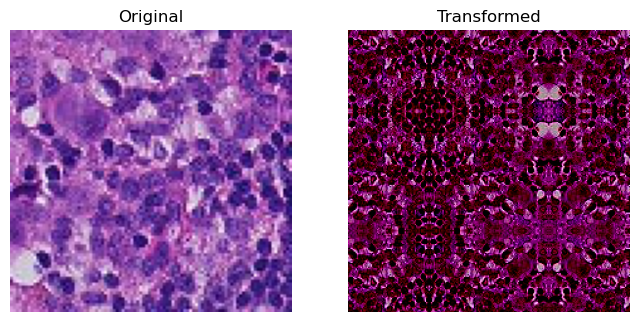

In [40]:
#primjer transformirane slike
import random 

rand_idx = int(random.random() * len(dataset_train))
image, label = dataset_train[rand_idx]

img_name = dataset_train.df[rand_idx][0]
img_path = os.path.join(dataset_train.data_dir, img_name + '.tif')

orig_image = cv2.imread(img_path)
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0) #(c, h, w) -> (h, w, c)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(orig_image)
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(image)
axs[1].set_title("Transformed")
axs[1].axis("off")

plt.show()

In [41]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1)
        self.conv6 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = 1)  
        self.bn1 = nn.BatchNorm2d(32)        
        self.bn2 = nn.BatchNorm2d(64)        
        self.bn3 = nn.BatchNorm2d(128)        
        self.bn4 = nn.BatchNorm2d(256)        
        self.bn5 = nn.BatchNorm2d(512)        
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, 2)
        self.dropout_conv = nn.Dropout(p=0.3)   
        self.dropout_fc = nn.Dropout(p=0.5)     

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.dropout_conv(x)  
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.pool(F.leaky_relu(self.bn6(self.conv6(x))))
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_fc(x)     
        x = self.fc(x)
        return x
        

In [42]:
num_epochs = 8
num_classes = 2
batch_size = 32
learning_rate = 0.002

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

gc.collect()
torch.cuda.empty_cache()

In [43]:
model = SimpleCNN().to(device)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [45]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [46]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    start = time.time()
    
    for step, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        if (step + 1) % 10 == 0:
            elapsed = time.time() - start
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{len(loader_train)}], "
                  f"Loss: {loss.item():.4f}, Time: {elapsed:.2f}s")
    
    avg_train_loss = running_loss / len(loader_train)
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_running_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader_valid:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    avg_val_loss = val_running_loss / len(loader_valid)
    val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Loss: {running_loss / len(loader_train):.4f}")

Epoch [1/8], Step [10/6189], Loss: 0.6713, Time: 3.12s
Epoch [1/8], Step [20/6189], Loss: 0.2638, Time: 5.86s
Epoch [1/8], Step [30/6189], Loss: 0.9182, Time: 8.66s
Epoch [1/8], Step [40/6189], Loss: 0.6831, Time: 11.57s
Epoch [1/8], Step [50/6189], Loss: 0.7341, Time: 14.47s
Epoch [1/8], Step [60/6189], Loss: 0.5720, Time: 17.30s
Epoch [1/8], Step [70/6189], Loss: 0.5252, Time: 20.07s
Epoch [1/8], Step [80/6189], Loss: 0.5877, Time: 22.77s
Epoch [1/8], Step [90/6189], Loss: 0.5124, Time: 25.46s
Epoch [1/8], Step [100/6189], Loss: 0.4705, Time: 28.29s
Epoch [1/8], Step [110/6189], Loss: 0.6098, Time: 31.02s
Epoch [1/8], Step [120/6189], Loss: 0.6095, Time: 33.72s
Epoch [1/8], Step [130/6189], Loss: 0.4438, Time: 36.43s
Epoch [1/8], Step [140/6189], Loss: 0.2408, Time: 39.11s
Epoch [1/8], Step [150/6189], Loss: 0.5148, Time: 41.83s
Epoch [1/8], Step [160/6189], Loss: 0.5436, Time: 44.66s
Epoch [1/8], Step [170/6189], Loss: 0.4768, Time: 47.35s
Epoch [1/8], Step [180/6189], Loss: 0.4825,

Epoch [4/8], Step [2030/6189], Loss: 0.1519, Time: 3891.00s
Epoch [4/8], Step [2040/6189], Loss: 0.0878, Time: 3910.01s
Epoch [4/8], Step [2050/6189], Loss: 0.0826, Time: 3929.12s
Epoch [4/8], Step [2060/6189], Loss: 0.1801, Time: 3948.78s
Epoch [4/8], Step [2070/6189], Loss: 0.1163, Time: 3968.17s
Epoch [4/8], Step [2080/6189], Loss: 0.3087, Time: 3987.46s
Epoch [4/8], Step [2090/6189], Loss: 0.0336, Time: 4006.73s
Epoch [4/8], Step [2100/6189], Loss: 0.1682, Time: 4025.76s
Epoch [4/8], Step [2110/6189], Loss: 0.2058, Time: 4045.14s
Epoch [4/8], Step [2120/6189], Loss: 0.3006, Time: 4064.49s
Epoch [4/8], Step [2130/6189], Loss: 0.0350, Time: 4083.54s
Epoch [4/8], Step [2140/6189], Loss: 0.1073, Time: 4102.62s
Epoch [4/8], Step [2150/6189], Loss: 0.1902, Time: 4122.33s
Epoch [4/8], Step [2160/6189], Loss: 0.1744, Time: 4141.81s
Epoch [4/8], Step [2170/6189], Loss: 0.1020, Time: 4160.75s
Epoch [4/8], Step [2180/6189], Loss: 0.2486, Time: 4180.59s
Epoch [4/8], Step [2190/6189], Loss: 0.1

Epoch [4/8], Step [3400/6189], Loss: 0.2321, Time: 6516.60s
Epoch [4/8], Step [3410/6189], Loss: 0.0594, Time: 6535.71s
Epoch [4/8], Step [3420/6189], Loss: 0.1494, Time: 6554.74s
Epoch [4/8], Step [3430/6189], Loss: 0.2339, Time: 6574.23s
Epoch [4/8], Step [3440/6189], Loss: 0.2092, Time: 6593.49s
Epoch [4/8], Step [3450/6189], Loss: 0.0724, Time: 6612.32s
Epoch [4/8], Step [3460/6189], Loss: 0.0583, Time: 6631.45s
Epoch [4/8], Step [3470/6189], Loss: 0.0860, Time: 6650.54s
Epoch [4/8], Step [3480/6189], Loss: 0.0219, Time: 6669.89s
Epoch [4/8], Step [3490/6189], Loss: 0.2152, Time: 6689.19s
Epoch [4/8], Step [3500/6189], Loss: 0.1037, Time: 6708.41s
Epoch [4/8], Step [3510/6189], Loss: 0.0747, Time: 6727.53s
Epoch [4/8], Step [3520/6189], Loss: 0.1840, Time: 6746.59s
Epoch [4/8], Step [3530/6189], Loss: 0.0995, Time: 6766.25s
Epoch [4/8], Step [3540/6189], Loss: 0.2057, Time: 6785.18s
Epoch [4/8], Step [3550/6189], Loss: 0.2244, Time: 6804.32s
Epoch [4/8], Step [3560/6189], Loss: 0.1

Epoch [4/8], Step [4770/6189], Loss: 0.2791, Time: 9149.24s
Epoch [4/8], Step [4780/6189], Loss: 0.1087, Time: 9168.42s
Epoch [4/8], Step [4790/6189], Loss: 0.2515, Time: 9187.40s
Epoch [4/8], Step [4800/6189], Loss: 0.1474, Time: 9206.35s
Epoch [4/8], Step [4810/6189], Loss: 0.0749, Time: 9225.47s
Epoch [4/8], Step [4820/6189], Loss: 0.1385, Time: 9244.82s
Epoch [4/8], Step [4830/6189], Loss: 0.0678, Time: 9264.29s
Epoch [4/8], Step [4840/6189], Loss: 0.2900, Time: 9283.51s
Epoch [4/8], Step [4850/6189], Loss: 0.2028, Time: 9302.47s
Epoch [4/8], Step [4860/6189], Loss: 0.1051, Time: 9321.65s
Epoch [4/8], Step [4870/6189], Loss: 0.4333, Time: 9341.02s
Epoch [4/8], Step [4880/6189], Loss: 0.1589, Time: 9360.27s
Epoch [4/8], Step [4890/6189], Loss: 0.1107, Time: 9379.48s
Epoch [4/8], Step [4900/6189], Loss: 0.2446, Time: 9398.78s
Epoch [4/8], Step [4910/6189], Loss: 0.0597, Time: 9417.97s
Epoch [4/8], Step [4920/6189], Loss: 0.2312, Time: 9437.77s
Epoch [4/8], Step [4930/6189], Loss: 0.2

Epoch [4/8], Step [6130/6189], Loss: 0.1401, Time: 11799.29s
Epoch [4/8], Step [6140/6189], Loss: 0.1773, Time: 11818.42s
Epoch [4/8], Step [6150/6189], Loss: 0.1706, Time: 11837.89s
Epoch [4/8], Step [6160/6189], Loss: 0.0464, Time: 11856.82s
Epoch [4/8], Step [6170/6189], Loss: 0.0911, Time: 11875.88s
Epoch [4/8], Step [6180/6189], Loss: 0.2115, Time: 11894.92s
Epoch [4/8] completed, Average Loss: 0.1504
Epoch [5/8], Step [10/6189], Loss: 0.0375, Time: 19.03s
Epoch [5/8], Step [20/6189], Loss: 0.1708, Time: 38.32s
Epoch [5/8], Step [30/6189], Loss: 0.0998, Time: 57.64s
Epoch [5/8], Step [40/6189], Loss: 0.0554, Time: 76.59s
Epoch [5/8], Step [50/6189], Loss: 0.1667, Time: 95.41s
Epoch [5/8], Step [60/6189], Loss: 0.0838, Time: 114.38s
Epoch [5/8], Step [70/6189], Loss: 0.1827, Time: 133.61s
Epoch [5/8], Step [80/6189], Loss: 0.1977, Time: 152.84s
Epoch [5/8], Step [90/6189], Loss: 0.1001, Time: 171.63s
Epoch [5/8], Step [100/6189], Loss: 0.0804, Time: 190.63s
Epoch [5/8], Step [110/6

KeyboardInterrupt: 

In [47]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    accuracy = correct / total * 100
    print(f'Test Accuracy of the model on {total} validation images: {accuracy:.2f} %')

# Save model
torch.save(model.state_dict(), 'model.ckpt')


Test Accuracy of the model on 22003 validation images: 95.30 %


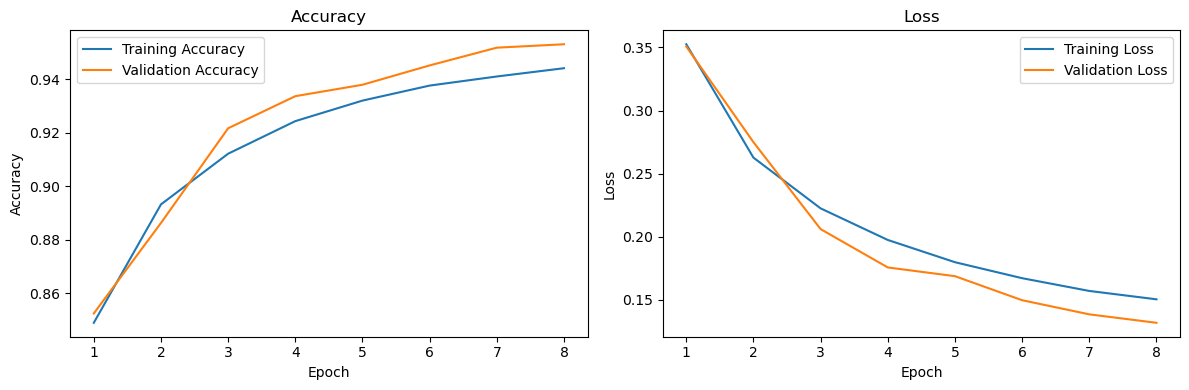

In [48]:
epochs = range(1, num_epochs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# graf za točnost 
ax1.plot(epochs, train_accuracies, label="Training Accuracy")
ax1.plot(epochs, val_accuracies, label="Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy")
ax1.legend()

# graf za gubitak
ax2.plot(epochs, train_losses, label="Training Loss")
ax2.plot(epochs, val_losses, label="Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss")
ax2.legend()

plt.tight_layout()
plt.show()

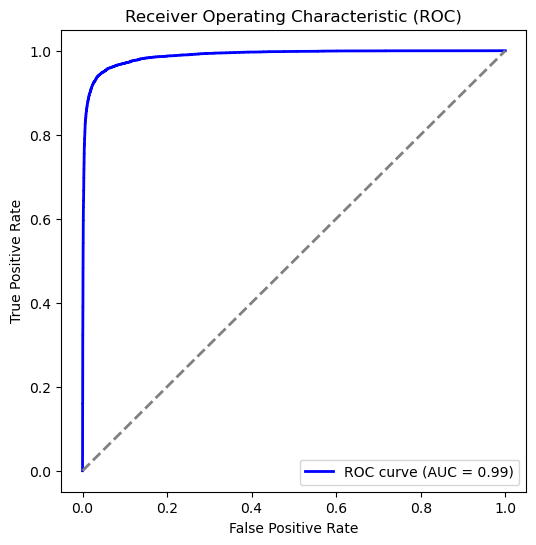

In [49]:
from sklearn.metrics import roc_curve, auc

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                   
        probs = torch.softmax(outputs, dim=1)     

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())   


fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

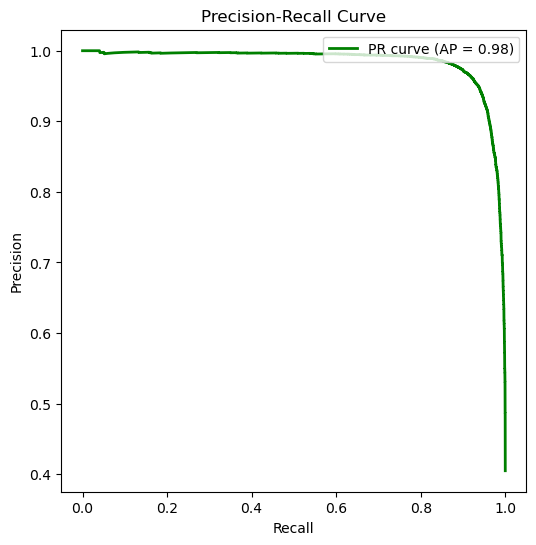

In [50]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
avg_prec = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color="green", lw=2,
         label=f"PR curve (AP = {avg_prec:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()

In [51]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.95      0.98      0.96     13091
    Positive       0.96      0.92      0.94      8912

    accuracy                           0.95     22003
   macro avg       0.96      0.95      0.95     22003
weighted avg       0.95      0.95      0.95     22003



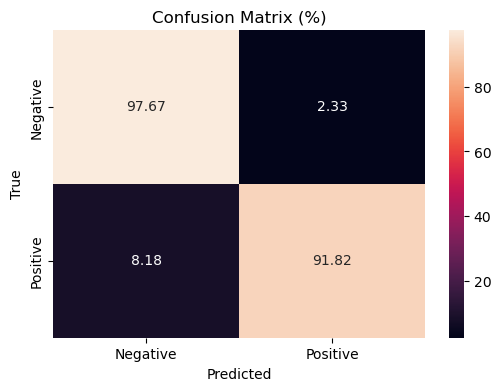

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_labels, all_preds)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,4))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="rocket", 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (%)")
plt.show()